In [116]:
import json
from copy import deepcopy
from collections import defaultdict, Counter
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import japanize_matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from beir.datasets.data_loader import GenericDataLoader
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pytrec_eval import RelevanceEvaluator
from tqdm import tqdm_notebook

from common import get_result_colbert, get_result, get_result_bm25, add_result

In [2]:
analyzer = Analyzer(get_lucene_analyzer())

In [3]:
plt.rcParams['font.family'] = 'IPAexGothic'
matplotlib.rcParams['font.family'] = 'IPAexGothic'
fp = FontProperties(fname='/home/iida.h/download/IPAexfont00401/ipaexm.ttf')
matplotlib.matplotlib_fname()
sns.set(font='IPAexGothic')
print(plt.rcParams['font.family'])

['IPAexGothic']


In [4]:
def calc_idf(corpus):
    N = len(corpus)
    idf = defaultdict(float)
    df = Counter()
    for cid, doc in tqdm_notebook(corpus.items()):
        text = doc["title"] + " " + doc["text"]
        t_doc = analyzer.analyze(text)
        df.update(list(set(t_doc)))
    
    for v, freq in df.items():
        idf[v] = np.log(N/freq)
    return df, idf

In [5]:
def calc_rsj(index_corpus, queries, qrels, N):
    rsj = {}
    for qid, q_qrels in qrels.items():
        try:
            query = queries[qid]
        except KeyError:
            continue
        t_query = analyzer.analyze(query)
        rel_q_qrels = {k: v for k, v in q_qrels.items() if v > 0}
        Nr = len([i for i in q_qrels.values() if i > 0])
        if Nr < 1:
            continue
        wtq = defaultdict(float)
        for t in t_query:
            Dt = index_corpus[t]
            Nt = len(Dt)
            Ntr = 0
            for did in Dt:
                if did in rel_q_qrels:
                    Ntr+= 1
                   
            pt = Ntr / Nr
            not_pt = (Nt - Ntr) / (N - Nr)
            wtq[t] = np.log(((Ntr + 0.5)*(N - Nt - Nr + Ntr + 0.5))/((Nr - Ntr + 0.5)*(Nt - Ntr + 0.5)) )
            # print(qid, t, N, Nt, Nr, Ntr, wtq[t], ((Ntr + 0.5)*(N - Nt - Nr + Ntr + 0.5)), (Nr - Ntr + 0.5)*(Nt - Ntr + 0.5))
        rsj[qid] = wtq
    return rsj

In [105]:
def df_diff_rsj(name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names):
    rsj_info_bin = []
    for name, all_rels in name_and_path.items():
        print(name)
        topK_rels = {}
        for qid, rels in all_rels.items():
            topK_rels[qid] = dict(sorted(rels.items(), key=lambda x: -x[1])[:100])

        rsj_s = calc_rsj(index_corpus, queries, topK_rels, N)

        for bin_name in bin_names:
            for qid in rsj_u:
                t_query = analyzer.analyze(queries[qid])
                for t in t_query:
                    try:
                        if bin_rsj_u[qid][t] == bin_name:
                            diff_rsj = rsj_s[qid][t] - rsj_u[qid][t]
                            rsj_info_bin.append((name, bin_name, diff_rsj))
                    except:
                        continue
                    
    df_rsj_info_bin = pd.DataFrame(rsj_info_bin, columns=["retriever", "bin", "ΔRSJ"])
    return df_rsj_info_bin
            

In [97]:
def stats(corpus, quries):
    df, idf = calc_idf(corpus)
    N = len(corpus)

    all_query_term = set()
    for query in queries.values():
        t_query = analyzer.analyze(query)
        all_query_term |= set(t_query)


    index_corpus = defaultdict(list)
    for cid, doc in corpus.items():
        text = doc["title"] + " " + doc["text"]
        t_doc = analyzer.analyze(text)
        for t in set(t_doc):
            index_corpus[t].append(cid)

    max_idf = int(np.ceil(np.max(list(idf.values()))))
    min_idf = int(np.floor(np.min(list(idf.values()))))
    return index_corpus, all_query_term, df, N
# bin_idf = {}
# for t in df:
#     if (df[t] / N) > (ms_df.get(t, 0) / ms_N) * 5:
#         if idf[t] > 5:
#             bin_idf[t] = "IDF+:Over5"
#         else:
#             bin_idf[t] = "IDF+:Under5"
#     else:
#         if idf[t] > 5:
#             bin_idf[t] = "IDF-:Over5"
#         else:
#             bin_idf[t] = "IDF-:Under5"

In [98]:
def bin_words_rsj_idf(index_corpus, queries, qrels, N, df, all_query_term):
    # mean_df = np.mean(list(df.values()))
    idf = {t: np.log(N/v) for t, v in df.items()}
    median_idf = np.median([v for t, v in idf.items() if t in all_query_term] )
    q75, q25 = np.percentile(list(idf.values()), [75 ,25])

    rsj_u = calc_rsj(index_corpus, queries, qrels, N)
    mq75, mq25 = np.percentile([v for qid, term_value in rsj_u.items() for t, v in term_value.items()], [75, 25])
    mq50 = np.median([v for qid, term_value in rsj_u.items() for t, v in term_value.items()])
    print(median_idf, mq75)

    bin_rsj_u = {}
    for t in idf:
        for qid, rsj_uq in rsj_u.items():
            if qid not in bin_rsj_u:
                bin_rsj_u[qid] = {}
            if t not in rsj_uq:
                bin_rsj_u[qid][t] = "OOV"
                continue
            if idf[t] < median_idf:
    #             bin_rsj_u[qid][t] = "LowIDF"
                if rsj_uq[t] > mq50:
                    bin_rsj_u[qid][t] = "HighRSJ:LowIDF"
                else:
                    bin_rsj_u[qid][t] = "LowRSJ:LowIDF"
            else:
    #             bin_rsj_u[qid][t] = "HighIDF"
                if rsj_uq[t] > mq50:
                    bin_rsj_u[qid][t] = "HighRSJ:HighIDF"
                else:
                    bin_rsj_u[qid][t] = "LowRSJ:HighIDF"
    return rsj_u, bin_rsj_u

In [99]:
def bin_words_rsj(index_corpus, queries, qrels, N, df, all_query_term):
    # mean_df = np.mean(list(df.values()))
    idf = {t: np.log(N/v) for t, v in df.items()}
    median_idf = np.median([v for t, v in idf.items() if t in all_query_term] )
    q75, q25 = np.percentile(list(idf.values()), [75 ,25])

    rsj_u = calc_rsj(index_corpus, queries, qrels, N)
    mq75, mq25 = np.percentile([v for qid, term_value in rsj_u.items() for t, v in term_value.items()], [75, 25])
    mq50 = np.median([v for qid, term_value in rsj_u.items() for t, v in term_value.items()])
    print(median_idf, mq75)

    bin_rsj_u = {}
    for t in idf:
        for qid, rsj_uq in rsj_u.items():
            if qid not in bin_rsj_u:
                bin_rsj_u[qid] = {}
            if t not in rsj_uq:
                bin_rsj_u[qid][t] = "OOV"
                continue
            if rsj_uq[t] >= mq75:
                bin_rsj_u[qid][t] = "HighRSJ"
            else:
                bin_rsj_u[qid][t] = "LowRSJ"
    return rsj_u, bin_rsj_u

In [89]:
dataset = "trec-covid"
vocab = "71694"
data_path = f"/home/gaia_data/iida.h/BEIR/datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

  0%|          | 0/171332 [00:00<?, ?it/s]

In [76]:
index_corpus, all_query_term, df, N = stats(corpus, queries)

<ipython-input-4-68e404270bb4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cid, doc in tqdm_notebook(corpus.items()):


  0%|          | 0/171332 [00:00<?, ?it/s]

In [103]:
rsj_u, bin_rsj_u = bin_words_rsj_idf(index_corpus, queries, qrels, N, df, all_query_term)

3.0065453711037673 3.0698663677368656


In [78]:
# idf = {t: np.log(N/v) for t, v in df.items()}
# median_idf = np.median([v for t, v in idf.items() if t in all_query_term] )
# q75, q25 = np.percentile(list(idf.values()), [75 ,25])

# rsj_u = calc_rsj(index_corpus, queries, qrels, N)
# mq75, mq25 = np.percentile([v for qid, term_value in rsj_u.items() for t, v in term_value.items()], [75, 25])
# print(median_idf, q75, mq75)

# bin_rsj_u_idf = {}
# for t in idf:
#     for qid, rsj_uq in rsj_u.items():
#         if qid not in bin_rsj_u_idf:
#             bin_rsj_u_idf[qid] = {}
#         if t not in rsj_uq:
#             bin_rsj_u_idf[qid][t] = "OOV"
#             continue
#         if idf[t] < q75:
#             bin_rsj_u_idf[qid][t] = "LowIDF"
#         else:
#             bin_rsj_u_idf[qid][t] = "HighIDF"

In [79]:
def top_ranked_count(index_corpus, queries, qrels, N):
    count = {}
    for qid, q_qrels in qrels.items():
        try:
            query = queries[qid]
        except KeyError:
            continue
        t_query = analyzer.analyze(query)
        rel_q_qrels = {k: v for k, v in q_qrels.items() if v > 0}
        t_count = defaultdict(float)
        for t in t_query:
            Dt = index_corpus[t]
            Nt = len(Dt)
            Ntr = 0
            for did in Dt:
                if did in rel_q_qrels:
                    Ntr+= 1
                    
            t_count[t] = Ntr
                   
        count[qid] = t_count
    return count
    

In [80]:
def df_top_ranked_count(name_and_path, bin_rsj_u, index_corpus, queries, N, bin_names):
    count_info_bin = []
    for name, path in name_and_path.items():
        with open(path) as f:
            all_rels = json.load(f)
        
        if name != "BM25":
            all_rels = list(all_rels.values())[0]
        topK_rels = {}
        for qid, rels in all_rels.items():
            topK_rels[qid] = dict(sorted(rels.items(), key=lambda x: -x[1])[:100])
            
        count_s = top_ranked_count(index_corpus, queries, topK_rels, N)

        for bin_name in bin_names:
            for qid in count_s:
                t_query = analyzer.analyze(queries[qid])
                for t in t_query:
                    try:
                        if bin_rsj_u[qid][t] == bin_name:
                            count_info_bin.append((name, bin_name, count_s[qid][t]))
                    except:
                        continue
                    
    df_count_info_bin = pd.DataFrame(count_info_bin, columns=["retriever", "bin", "count"])
    return df_count_info_bin
            
    
            
        

In [81]:
def path2result(key2path, dataset, base_model_name=None):
    key2result = {}
    for key, path in key2path.items():
        if key == "ColBERT":
            colbert_root_dir = Path("/home/gaia_data/iida.h/BEIR/colbert/")
            colbert_dataset_dir = colbert_root_dir.joinpath("datasets", dataset)
            all_rels = get_result_colbert(path, colbert_dataset_dir)
        elif key == "BM25":
            all_rels = get_result_bm25(Path(path))
        else:
            all_rels = get_result(Path(path))
            
        key2result[key] = all_rels
    if base_model_name is not None:
        base_result = key2result[base_model_name]
        tmp_key2result = {}
        for key, res in key2result.items():
            if key == base_model_name:
                continue
            new_key = f"{base_model_name}+{key}"
            new_res = deepcopy(base_result)
            for qid, d2score in res.items():
                if qid not in new_res:
                    new_res[qid] = d2score
                for did, score in d2score.items():
                    if did not in new_res[qid]:
                        new_res[qid][did] = score
                    else:
                        new_res[qid][did] += score
            tmp_key2result[new_key] = new_res
        key2result.update(**tmp_key2result)
    return key2result
        
        

In [82]:
gpl_analysis_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/bm25/analysis.json",
    "Dense": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/dense-org/analysis.json",
    "Dense-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/dense-gpl-self-org/30522/analysis.json",
    "Dense-AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/mlm-dense-org/{vocab}/analysis.json",
    "Dense-AdaLM-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/mlm-dense-gpl-self-org/{vocab}/analysis.json",
}

In [83]:
gpl_analysis_result = path2result(gpl_analysis_path, dataset, None)
gpl_analysis_result.keys()

dict_keys(['BM25', 'Dense', 'Dense-GPL', 'Dense-AdaLM', 'Dense-AdaLM-GPL'])

BM25
Dense
Dense-GPL
Dense-AdaLM
Dense-AdaLM-GPL


<ipython-input-106-5d38c5231472>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)


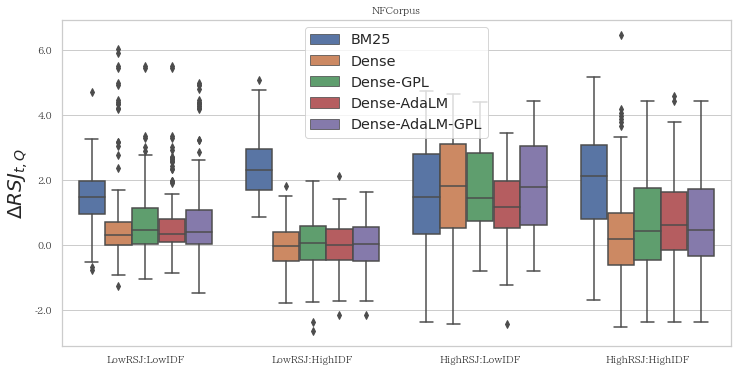

<Figure size 432x288 with 0 Axes>

In [106]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
# bin_names = ["HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(gpl_analysis_result, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=20, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig3-2.svg", format="svg")

In [63]:
def improve_worse_queries(result1, result2, qrels, threshold=0.05):
    evaluator = RelevanceEvaluator(qrels, {'ndcg_cut'})
    ndcg_result1 = evaluator.evaluate(result1)
    ndcg_result2 = evaluator.evaluate(result2)
    query = {"improve": [], "worse": []}
    for qid in qrels:
        try:
            q_ndcg_result1 = ndcg_result1[qid]["ndcg_cut_100"]
            q_ndcg_result2 = ndcg_result2[qid]["ndcg_cut_100"]
        except KeyError:
            continue
        diff = q_ndcg_result2 - q_ndcg_result1
        abs_diff = np.abs(diff)
        if abs_diff > threshold:
            if diff > 0.0:
                query["improve"].append((qid, diff))
            else:
                query["worse"].append((qid, diff))
    return query
        


In [64]:
iwq = improve_worse_queries(gpl_analysis_result["Dense-AdaLM"], gpl_analysis_result["Dense-AdaLM-GPL"], qrels)
improve = []
worse = []
print("improve")
ic = defaultdict(int)
wo = defaultdict(int)
for qid, diff in iwq["improve"]:
    tmp = []
    query = queries[qid]
    t_query = analyzer.analyze(query)
    for t in t_query:
        tmp.append(bin_rsj_u[qid][t])
        improve.extend(list(tmp))
    for t in set(tmp):
        ic[t] += 1
        
print("worse")
for qid, diff in iwq["worse"]:
    tmp = []
    query = queries[qid]
    t_query = analyzer.analyze(query)
    for t in t_query:
        tmp.append(bin_rsj_u[qid][t])
        worse.extend(list(tmp))
    for t in set(tmp):
        wo[t] += 1
    
# ic = Counter(improve)
for k, v in ic.items():
    ic[k] = v / len(iwq["improve"])
#  wo = Counter(worse)
for k, v in wo.items():
    wo[k] = v / len(iwq["worse"])

pprint(ic)
pprint(wo)

improve


KeyError: 'p150n'

In [ ]:
gen_q = {}
global_rsj = {}
for qid, values in bin_rsj_u.items():
    for t, v in values.items():
        global_rsj[t] = v
# gen_q_info = []
gen_q_info = defaultdict(int)

with open("/home/gaia_data/iida.h/BEIR/splade_vocab/generated-self/trec-covid/mlm-dense/71694/qgen-queries.jsonl") as f:
    for line in f:
        jline = json.loads(line)
        qid = jline["_id"]
        text = jline["text"]
        gen_q[qid] = text
        
for qid, query in gen_q.items():
    tmp = []
    t_query = analyzer.analyze(query)
    for t in t_query:
        if t in global_rsj:
            tmp.append(global_rsj[t])
    for t in set(tmp):
        gen_q_info[t] += 1
          
for k, v in gen_q_info.items():
    gen_q_info[k] /= len(gen_q)

pprint(gen_q_info)
# Counter(gen_q_info)

In [107]:
# dataset = "scifact"
# vocab = "62783"
dataset = "nfcorpus"
vocab = "71694"
data_path = f"/home/gaia_data/iida.h/BEIR/datasets/{dataset}"
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

  0%|          | 0/3633 [00:00<?, ?it/s]

In [108]:
index_corpus, all_query_term, df, N = stats(corpus, queries)
rsj_u, bin_rsj_u = bin_words_rsj_idf(index_corpus, queries, qrels, N, df, all_query_term)

<ipython-input-4-68e404270bb4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cid, doc in tqdm_notebook(corpus.items()):


  0%|          | 0/3633 [00:00<?, ?it/s]

4.560227872494816 4.094654548604004


In [67]:
gpl_analysis_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/bm25/analysis.json",
    "Splade": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/splade-org/analysis.json",
    "Splade-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/splade-gpl-self-org/analysis.json",
    "Splade-AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/mlm-splade-org/{vocab}/analysis.json",
    "Splade-AdaLM-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/mlm-splade-gpl-self-org/{vocab}/analysis.json",
}

In [113]:
from common import add_result

splade_analysis_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/bm25/analysis.json",
    "SPLADE": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/splade-org/analysis.json",
    "SPLADE+GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/splade-gpl-self-org/analysis.json",
    "SPLADE+AdaLM": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/mlm-splade-org/{vocab}/analysis.json",
}

with open(splade_analysis_path["BM25"]) as fIn:
    bm25_result = json.load(fIn)
    
with open(splade_analysis_path["SPLADE+AdaLM"]) as fIn:
    splade_adalm_result = json.load(fIn)["org"]
    
splade_analysis_result = path2result(splade_analysis_path, dataset, None)
    
bm25_hybrid_result = add_result(bm25_result, splade_adalm_result)

splade_analysis_result["SPLADE+AdaLM+BM25併用"] = bm25_hybrid_result

In [114]:
gpl_analysis_result = path2result(gpl_analysis_path, dataset, None)
gpl_analysis_result.keys()

dict_keys(['BM25', 'Dense', 'Dense-GPL', 'Dense-AdaLM', 'Dense-AdaLM-GPL'])

BM25
SPLADE
SPLADE+GPL
SPLADE+AdaLM
SPLADE+AdaLM+BM25併用


<ipython-input-139-2693a57920cf>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)


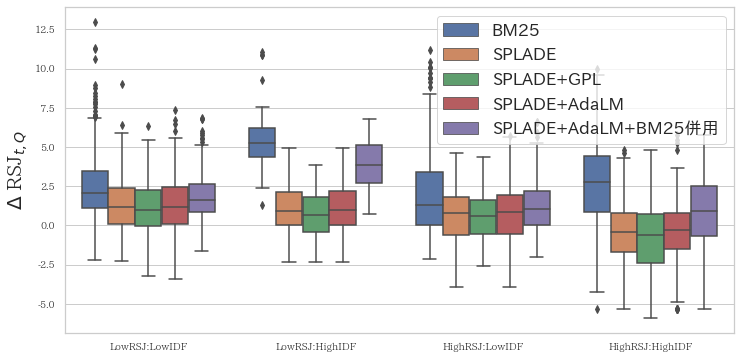

<Figure size 432x288 with 0 Axes>

In [139]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
# bin_names = ["HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(splade_analysis_result, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
matplotlib.rcParams['font.family'] = 'IPAexGothic'
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
# p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("$\Delta$ RSJ$_{t,Q}$", fontsize=20, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig5-3-rsj.svg", format="svg")

In [140]:
df_splade_rsj_info_bin.groupby(by=["bin", "retriever"]).median()
# df_splade_rsj_info_bin.head()

ΔRSJ
bin             retriever                    
HighRSJ:HighIDF BM25                 2.743449
                SPLADE              -0.401206
                SPLADE+AdaLM        -0.292437
                SPLADE+AdaLM+BM25併用  0.927685
                SPLADE+GPL          -0.586444
HighRSJ:LowIDF  BM25                 1.309945
                SPLADE               0.782293
                SPLADE+AdaLM         0.851330
                SPLADE+AdaLM+BM25併用  1.040696
                SPLADE+GPL           0.609218
LowRSJ:HighIDF  BM25                 5.268922
                SPLADE               0.940983
                SPLADE+AdaLM         0.963126
                SPLADE+AdaLM+BM25併用  3.876701
                SPLADE+GPL           0.647667
LowRSJ:LowIDF   BM25                 2.051523
                SPLADE               1.175448
                SPLADE+AdaLM         1.164535
                SPLADE+AdaLM+BM25併用  1.599429
                SPLADE+GPL           0.971739

In [ ]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
# bin_names = ["HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(gpl_analysis_result, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=20, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig3-2.svg", format="svg")

In [ ]:
colbert_root_dir = Path("/home/gaia_data/iida.h/BEIR/colbert/")
colbert_dir = colbert_root_dir.joinpath("experiments", "Distilcolbert-self", dataset)   
colbert_path = list(colbert_dir.glob("*search/2022-12/29/**/*.tsv"))[0]
ensemble_analysis_path = {
    "BM25": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/bm25/analysis.json",
    "密ベクトル検索": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/dense-org/analysis.json",
    # "SPLADE": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/splade-org/analysis.json",
    # "ColBERT": colbert_path,
    # "AdaLM-Dense-GPL": f"/home/gaia_data/iida.h/BEIR/splade_vocab/evaluation/{dataset}/mlm-dense-gpl-self-org/62783/analysis.json",
}

In [ ]:
ensemble_analysis_result = path2result(ensemble_analysis_path, dataset, "密ベクトル検索")
ensemble_analysis_result.keys()

In [ ]:
plt.rcParams['font.family'] = 'IPAexGothic'
matplotlib.rcParams['font.family'] = 'IPAexGothic'
fp = FontProperties(fname='/home/iida.h/download/IPAexfont00401/ipaexm.ttf')
matplotlib.matplotlib_fname()
sns.set(font='IPAexGothic')
print(plt.rcParams['font.family'])

In [ ]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
# bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
bin_names = ["LowRSJ", "HighRSJ"]
df_splade_rsj_info_bin = df_diff_rsj(ensemble_analysis_result, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
sns.set(font="IPAexGothic", style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_title("Scifact", fontsize=20)
p.set_xticklabels(bin_names, fontsize=16)
p.set_yticklabels(p.get_yticks(), fontsize=16)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20)
p.set_xlabel("", fontsize=20)
p.set_ylabel(r"$\Delta \mathrm{RSJ}_{t,Q}$", fontsize=20)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("rsj.svg", format="svg")

In [27]:
df_splade_rsj_info_bin.groupby(by=["retriever", "bin"]).median()

NameError: name 'df_splade_rsj_info_bin' is not defined

In [28]:
print(plt.rcParams['font.family'])

['IPAexGothic']


/tmp/ipykernel_965576/2513229182.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)
/tmp/ipykernel_965576/2513229182.py:22: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  fig.savefig("fig-presen.svg", format="svg")
/tmp/ipykernel_965576/2513229182.py:22: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from current font.
  fig.savefig("fig-presen.svg", format="svg")
/tmp/ipykernel_965576/2513229182.py:22: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.savefig("fig-presen.svg", format="svg")
/tmp/ipykernel_965576/2513229182.py:22: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.savefig("fig-presen.svg", format="svg")
/tmp/ipykernel_965576/2513229182.py:22: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  fig.savefig("fig-presen.svg", format="

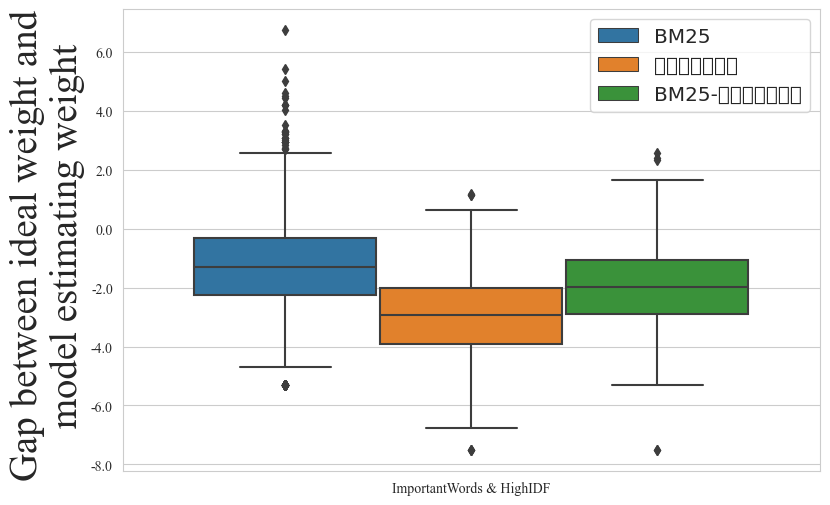

<Figure size 640x480 with 0 Axes>

In [220]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(ensemble_analysis_result, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
df_splade_rsj_info_bin = df_splade_rsj_info_bin[df_splade_rsj_info_bin["bin"] == "HighRSJ:HighIDF"]
df_splade_rsj_info_bin.replace("HighRSJ:HighIDF", "ImportantWords & HighIDF", inplace=True)
bin_names = ["ImportantWords & HighIDF"]
fig, ax = plt.subplots(figsize=(9, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
# p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=24, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("Gap between ideal weight and \n model estimating weight", fontsize=28, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig-presen.svg", format="svg")

/tmp/ipykernel_1352881/1528536802.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)


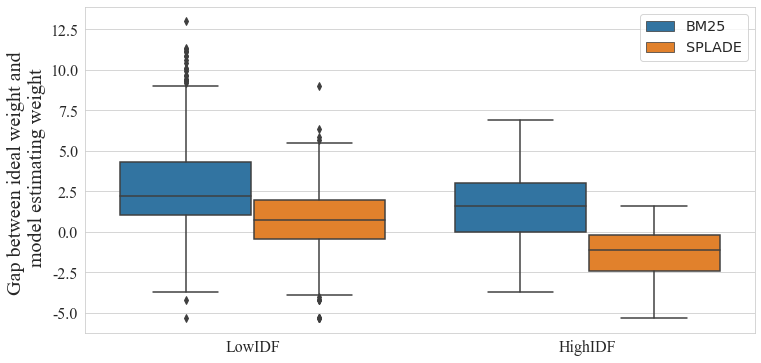

<Figure size 432x288 with 0 Axes>

In [62]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
# bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(for_intro_and_path, rsj_u, bin_rsj_u_idf, index_corpus, queries, N, bin_names)
# df_splade_top_ranked_count = df_top_ranked_count(for_intro_and_path, bin_rsj_u_idf, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
# p.set_title("NFCorpus", fontsize=20, fontproperties=fp)
p.set_xticklabels(bin_names, fontsize=16, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=16, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=20, fontproperties=fp)
p.set_ylabel("Gap between ideal weight and \n model estimating weight", fontsize=20, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("fig_presen.svg", format="svg")

/tmp/ipykernel_3743650/2017488400.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)


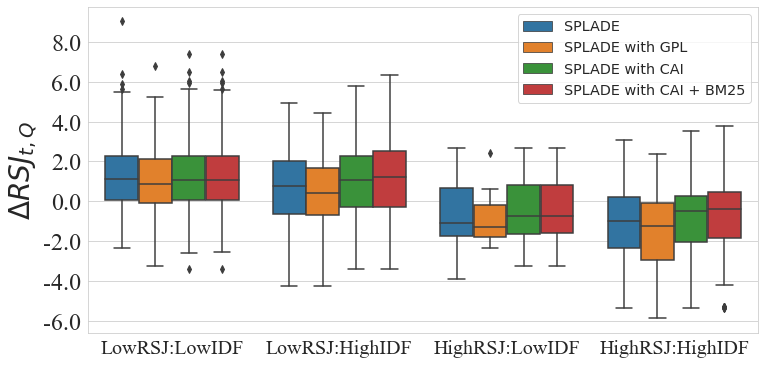

<Figure size 432x288 with 0 Axes>

In [20]:
# bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
# bin_names = ["LowIDF:Under5", "LowIDF:Under5", "HighIDF:Over5", "HighIDF:Over5"]
# bin_names = ["LowIDF", "HighIDF"]
# bin_names = ["LowIDF:LowRSJ", "LowIDF:LowRSJ", "HighIDF:HighRSJ", "HighIDF:HighRSJ"]
bin_names = ["LowRSJ:LowIDF", "LowRSJ:HighIDF", "HighRSJ:LowIDF", "HighRSJ:HighIDF"]
df_splade_rsj_info_bin = df_diff_rsj(comp_tk_name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_splade_rsj_info_bin, ax=ax)
p.set_xticklabels(bin_names, fontsize=20, fontproperties=fp)
p.set_yticklabels(p.get_yticks(), fontsize=24, fontproperties=fp)
# p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20, fontproperties=fp)
p.set_xlabel("", fontsize=28, fontproperties=fp)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=28, fontproperties=fp)
plt.legend(fontsize='x-large')
fig = plt.figure()
fig = p.get_figure()
fig.savefig("yans.svg", format="svg")

/tmp/ipykernel_330053/3515029374.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(p.get_yticks(), fontsize=16)


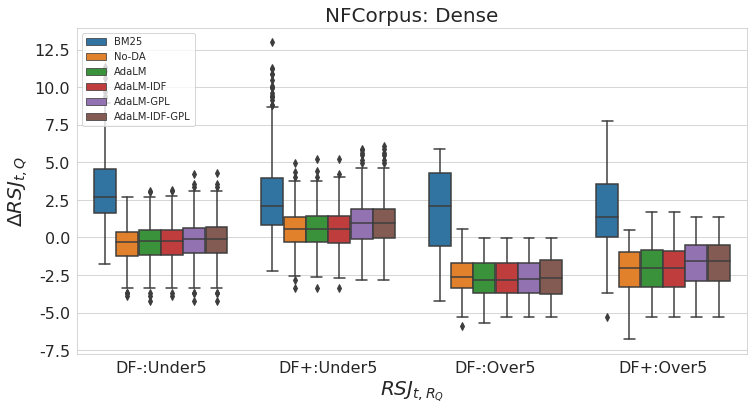

In [24]:
bin_names = ["DF-:Under5", "DF+:Under5", "DF-:Over5", "DF+:Over5"]
df_dense_rsj_info_bin = df_diff_rsj(dense_name_and_path, rsj_u, bin_rsj_u, index_corpus, queries, N, bin_names)
ig, ax = plt.subplots(figsize=(12, 6))
sns.set_style(style="whitegrid")
p = sns.boxplot(x='bin', y='ΔRSJ', hue="retriever", data=df_dense_rsj_info_bin, ax=ax)
p.set_title("NFCorpus: Dense", fontsize=20)
p.set_xticklabels(bin_names, fontsize=16)
p.set_yticklabels(p.get_yticks(), fontsize=16)
p.set_xlabel("$RSJ_{t, R_Q}$", fontsize=20)
p.set_ylabel("$\Delta RSJ_{t,Q}$", fontsize=20)
plt.legend(loc='upper left')